In [ ]:
from src.preprocessing import clean_text_column
from src.vectorization import build_tfidf
from src.models import build_logistic
from src.evaluation import evaluate


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "xcarsona",\r\n  "key": "KGAT_2bd083f9ef4f1ed549af712bf0b74534"\r\n}\r\n'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list | head


ref                                                   title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                              Heart Disease                                   3491  2025-12-11 15:29:14.327000           2114        123  1.0              
neurocipher/student-performance                       Student Performance                            49705  2025-12-12 12:06:28.973000           1261         89  1.0              
suvidyasonawane/student-performance-dataset           Student Performance Dataset                    81679  2025-12-25 05:27:51.453000              0         40  1.0              
wardabilal/spotify-global-music-dataset-20092025      Spotify Global Music Dataset (2009–2025)     1

In [ ]:
!kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health
!unzip sentiment-analysis-for-mental-health.zip


Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
sentiment-analysis-for-mental-health.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment-analysis-for-mental-health.zip
replace Combined Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!ls


'Combined Data.csv'   sample_data
 data_cleaned.csv     sentiment-analysis-for-mental-health.zip


In [ ]:
import pandas as pd

df = pd.read_csv("Combined Data.csv")  # adjust filename if needed
print(df.shape)
df.head()


(53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
sns.set_style("whitegrid")


In [ ]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.default'] = 'regular'


In [ ]:
df = pd.read_csv("Combined Data.csv")
print("Shape:", df.shape)
df.head()


Shape: (53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
df = df.rename(columns={
    df.columns[0]: "text",
    df.columns[1]: "label"
})

df.head()


,text,label,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.isnull().sum()
df.dropna(subset=['label'], inplace=True)
print("Shape after dropping nulls:", df.shape)
print(df.isnull().sum())

Shape after dropping nulls: (52681, 3)
text      0
label     0
status    0
dtype: int64


In [ ]:
status_counts = df["status"].value_counts()
print(status_counts)

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


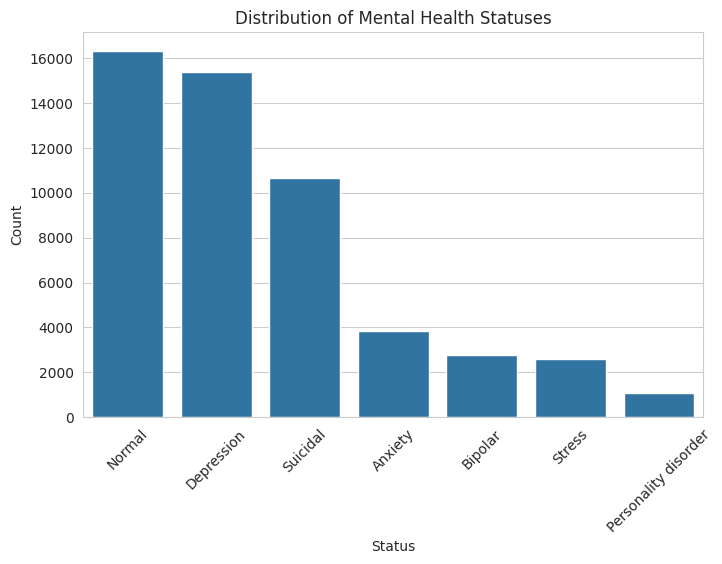

In [ ]:
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title("Distribution of Mental Health Statuses")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
for label in status_counts.index[:3]:
    print(f"\n--- Sample text for label: {label} ---")
    sample = df[df["status"] == label]["label"].iloc[0]
    print(sample)


--- Sample text for label: Normal ---
Gr gr dreaming of ex crush to be my game, God

--- Sample text for label: Depression ---
I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all this pain can stop it hurts so much and I cannot even cry about it. I do not want to hurt her because she said she does not want to never speak to me again but I do not know what to do here. When we were together she always hurt me so I do not know why I still love her. I wish we never met it would be much less painful How do I lose feelings?

--- Sample text for label: Suicidal ---
I am so exhausted of this. Just when I think I can finally rest, just when I think maybe things are starting to settle, another hurdle comes flying at me. This month alone we found out my mum could be dying, my girlfriend left me, my parents revealed that they wanted a divorce, my grand

In [ ]:
df["text_length"] = df["label"].apply(lambda x: len(str(x).split()))

df["text_length"].describe()

,text_length
count,52681.000000
mean,113.158729
std,163.735305
min,1.000000
25%,15.000000
50%,62.000000
75%,148.000000
max,6300.000000


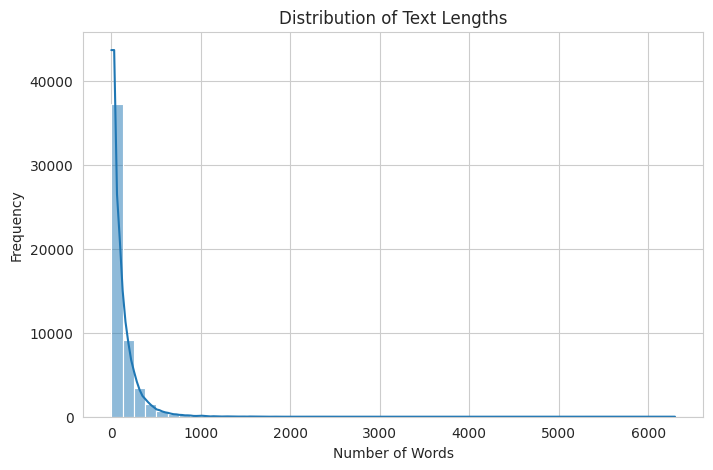

In [ ]:
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


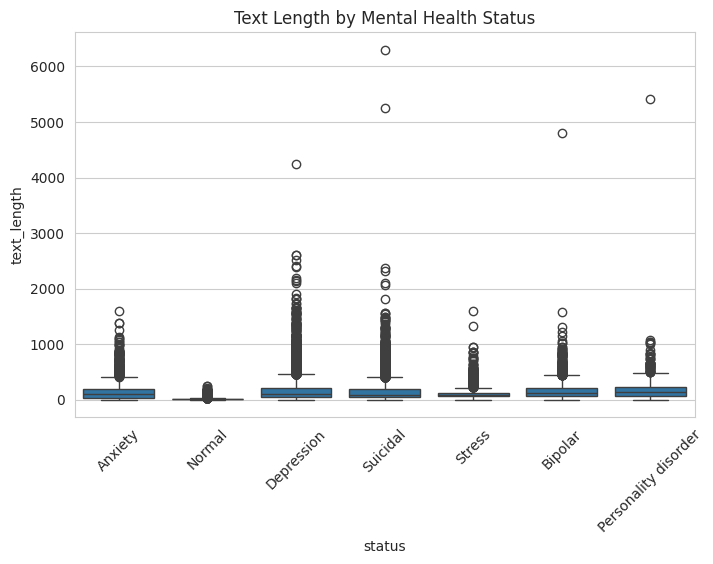

In [ ]:
sns.boxplot(x="status", y="text_length", data=df)
plt.xticks(rotation=45)
plt.title("Text Length by Mental Health Status")
plt.show()

In [ ]:
df.to_csv("data_cleaned.csv", index=False)
print("Saved data_cleaned.csv")


Saved data_cleaned.csv


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# --- LOAD DATA ---
# Update filename if needed
df = pd.read_csv("data_cleaned.csv")

# Expected columns:
# "text"   -> transcript / utterance
# "label"  -> binary or multiclass label (e.g., depressed vs control)

print(df.head())
print(df["label"].value_counts())

# --- TEXT CLEANING ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()     # normalize whitespace
    return text

df["clean_text"] = df["label"].astype(str).apply(clean_text)

# --- TF-IDF VECTORIZATION ---
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["status"] # Use 'status' column as the target variable

print("TF-IDF shape:", X.shape)

# --- TRAIN / TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

   text                                              label   status  \
0     0                                         oh my gosh  Anxiety   
1     1  trouble sleeping, confused mind, restless hear...  Anxiety   
2     2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3     3  I've shifted my focus to something else but I'...  Anxiety   
4     4  I'm restless and restless, it's been a month n...  Anxiety   

   text_length  
0            3  
1           10  
2           14  
3           11  
4           14  
label
what do you mean?                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- TRAIN BASELINE MODEL ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- PREDICTIONS ---
y_pred = model.predict(X_test)

# --- EVALUATION ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7658726392711398

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.83      0.74      0.79       768
             Bipolar       0.86      0.71      0.78       556
          Depression       0.71      0.74      0.73      3081
              Normal       0.84      0.95      0.89      3269
Personality disorder       0.83      0.51      0.63       215
              Stress       0.67      0.43      0.53       517
            Suicidal       0.69      0.65      0.67      2131

            accuracy                           0.77     10537
           macro avg       0.78      0.68      0.72     10537
        weighted avg       0.76      0.77      0.76     10537


Confusion Matrix:
 [[ 572   18   59   72    4   37    6]
 [  14  394   74   49    4   16    5]
 [  29   20 2293  173    6   17  543]
 [  17    5   82 3098    4   28   35]
 [   5    7   48   29  110   11    5]
 [  46   12   93  118    5  224   19]
 [   3    4  

In [ ]:
import numpy as np
import pandas as pd

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get coefficients
coefficients = model.coef_[0]

# Create dataframe
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# Sort by absolute importance
coef_df["abs_coeff"] = coef_df["coefficient"].abs()
top_features = coef_df.sort_values("abs_coeff", ascending=False).head(20)

top_features


,feature,coefficient,abs_coeff
3650,restless,8.284220,8.284220
152,anxiety,8.151946,8.151946
165,anxious,6.385574,6.385574
4925,worried,5.831515,5.831515
3032,nervous,5.285313,5.285313
4927,worry,4.408975,4.408975
512,cancer,3.640182,3.640182
1850,health anxiety,3.355353,3.355353
2025,im,3.261444,3.261444
4228,symptoms,3.260296,3.260296


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring="accuracy"
)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.70570371 0.7409833  0.71127563 0.77515186 0.69058466]
Mean CV accuracy: 0.72473983098499


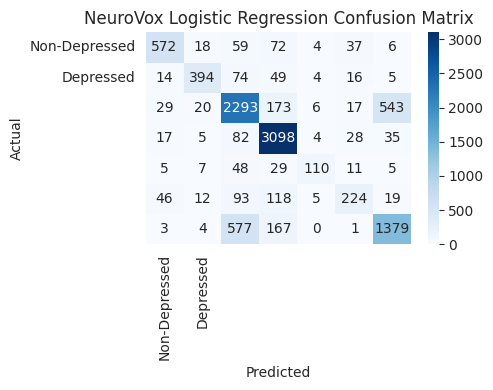

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Depressed", "Depressed"],
            yticklabels=["Non-Depressed", "Depressed"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NeuroVox Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict
svm_pred = svm_model.predict(X_test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))


SVM Accuracy: 0.7622662997057986

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.81      0.76      0.79       768
             Bipolar       0.81      0.75      0.78       556
          Depression       0.72      0.72      0.72      3081
              Normal       0.84      0.94      0.89      3269
Personality disorder       0.78      0.60      0.68       215
              Stress       0.66      0.47      0.55       517
            Suicidal       0.67      0.64      0.66      2131

            accuracy                           0.76     10537
           macro avg       0.76      0.70      0.72     10537
        weighted avg       0.76      0.76      0.76     10537



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import re

# --- LOAD DATA AND CLEAN TEXT (REPEATED FOR SELF-CONTAINED EXECUTION) ---
df = pd.read_csv("data_cleaned.csv")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()     # normalize whitespace
    return text

df["clean_text"] = df["label"].astype(str).apply(clean_text)

# Re-vectorize with unigrams + bigrams
vectorizer_bigram = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=15000 # Increased max_features for unigrams and bigrams
)

X_bigram = vectorizer_bigram.fit_transform(df["clean_text"])
y = df["status"] # Use 'status' column as the target variable, consistent with previous models

# Train/test split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bigram, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
bigram_model = LogisticRegression(max_iter=1000)
bigram_model.fit(Xb_train, yb_train)

# Evaluate
yb_pred = bigram_model.predict(Xb_test)
print("Bigram Model Accuracy:", accuracy_score(yb_test, yb_pred))

Bigram Model Accuracy: 0.7648286988706463
